In [ ]:
from IPython.display import display
import IPython
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn as skl
%matplotlib notebook
%matplotlib inline
import tensorflow as tf
!pip install mglearn
!pip install gensim
!pip install nltk
import nltk
import mglearn as mglearn
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

     |████████████████████████████████| 542kB 2.8MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=9f6498d6eb2239bfeb05288aba3ba54a8340a5494a7d74d31d2d6a82cc7a9800
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [ ]:
! wget -nc http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data
! tar xzf data/aclImdb_v1.tar.gz --skip-old-files -C data
#저 링크에서 압축파일을 받아서 압축을 풀겠다 라는 것이지

--2020-09-02 13:42:29--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  22.3MB/s    in 5.2s    

2020-09-02 13:42:35 (15.6 MB/s) - ‘data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tree data/aclImdb
!find ./data -type d

/bin/bash: tree: command not found
./data
./data/aclImdb
./data/aclImdb/train
./data/aclImdb/train/neg
./data/aclImdb/train/pos
./data/aclImdb/train/unsup
./data/aclImdb/test
./data/aclImdb/test/neg
./data/aclImdb/test/pos


In [ ]:
!rm -r data/aclImdb/train/unsup
#unpsup 파일을 지우겠다 는 뜻

rm: cannot remove 'data/aclImdb/train/unsup': No such file or directory


# 데이터 불러오기

IMDb is an online database owned by Amazon of information related to films, television programs, home videos, video games, and streaming content online – including cast, production crew and personal biographies, plot summaries, trivia, ratings, and fan and critical reviews.

In [ ]:
from sklearn.datasets import load_files

Train Data

In [ ]:
reviews_train = load_files("data/aclImdb/train/")
# 텍스트와 레이블을 포함하고 있는 Bunch 오브젝트를 반환합니다.
text_train, y_train = reviews_train.data, reviews_train.target
print("text_train의 타입:", type(text_train))
print("text_train의 길이:", len(text_train))
print("text_train[6]:\n", text_train[0])

#corpus : datasets > document : sample
# 25,000개의 sample이 있는 거고

text_train의 타입: <class 'list'>
text_train의 길이: 25000
text_train[6]:
 b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."


In [ ]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [ ]:
print(y_train)

[1 0 1 ... 0 0 0]


In [ ]:
print("클래스별 샘플 수 (훈련 데이터):", np.bincount(y_train))
# 정확히 반 반 나뉘어 져있음

클래스별 샘플 수 (훈련 데이터): [12500 12500]


Test Data

In [ ]:
reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("테스트 데이터의 문서 수:", len(text_test))
print("클래스별 샘플 수 (테스트 데이터):", np.bincount(y_test))
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]
#얘도 반반 나뉘어져 있음

테스트 데이터의 문서 수: 25000
클래스별 샘플 수 (테스트 데이터): [12500 12500]


# BOW 만들기 : 토큰화, 어휘 사전 구축(Vocabulary), 인코딩

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

#### 0. 生으로 바로 분류기 넣었을 때 : without any grid search or sth

In [ ]:
vect = CountVectorizer().fit(text_train) #사이킷런의 CountVetorizer로 토큰화
X_train = vect.transform(text_train) # 토큰화 시킨 훈련 데이터 셋
print("X_train:\n", repr(X_train))

X_train:
 <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names() #여기서 말하는 특성은 곧 토큰화된 단어들
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\n", feature_names[:20])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 2000번째 특성:\n", feature_names[::2000])

# 숫자가 먼저 나오고 알파벳순으로 그 다음 쭉

특성 개수: 74849
처음 20개 특성:
 ['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
20010에서 20030까지 특성:
 ['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
매 2000번째 특성:
 ['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("크로스 밸리데이션 평균 점수: {:.2f}".format(np.mean(scores)))

크로스 밸리데이션 평균 점수: 0.88


In [ ]:
lrm=LogisticRegression(max_iter=1000)
lrm.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:

X_test = vect.transform(text_test) # 토큰화 시킨 훈련 데이터 셋
print("테스트 점수: {:.2f}".format(lrm.score(X_test, y_test)))

테스트 점수: 0.87


#### 1. 단어의 수를 줄이는 방법 : min_df, 최소 n개 이상의 document에 등장하는 단어만 고르기

In [ ]:
vect = CountVectorizer(min_df=5).fit(text_train) #여기서는 n=5
X_train = vect.transform(text_train) # 토큰화 시킨 훈련 데이터 셋
print("X_train:\n", repr(X_train))

X_train:
 <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names() #여기서 말하는 특성은 곧 토큰화된 단어들
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\n", feature_names[:20])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 2000번째 특성:\n", feature_names[::2000])

#단어가 74,849에서 27,271로 떨어짐
#숫자는 아직 남아있고

특성 개수: 27271
처음 20개 특성:
 ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']
20010에서 20030까지 특성:
 ['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
매 2000번째 특성:
 ['00', 'baked', 'centipede', 'cutlery', 'elton', 'gaining', 'ideals', 'leering', 'moxy', 'picasso', 'repartee', 'silvers', 'talkative', 'verisimilitude']


In [ ]:
scores = cross_val_score(LogisticRegression(max_iter=1000), X_train, y_train, cv=5)
print("크로스 밸리데이션 평균 점수: {:.2f}".format(np.mean(scores)))

#별 차이 없네

크로스 밸리데이션 평균 점수: 0.88


In [ ]:
lrm=LogisticRegression(max_iter=1000)
lrm.fit(X_train, y_train)
X_test = vect.transform(text_test) # 토큰화 시킨 훈련 데이터 셋
print("테스트 점수: {:.2f}".format(lrm.score(X_test, y_test)))

테스트 점수: 0.86


#### 2. min_df, 그리드 서치 동시

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

# 별 차이 또 없음

최상의 크로스 밸리데이션 점수: 0.89
최적의 매개변수:  {'C': 0.1}


In [ ]:
lrm=LogisticRegression(max_iter=1000,C=0.1)
lrm.fit(X_train, y_train)
X_test = vect.transform(text_test) # 토큰화 시킨 훈련 데이터 셋
print("테스트 점수: {:.2f}".format(lrm.score(X_test, y_test)))

테스트 점수: 0.88


#### 3. min_df, 그리드서치, 불용어 제거

In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("불용어 개수:", len(ENGLISH_STOP_WORDS))
print("20번째까지 불용어:\n", list(ENGLISH_STOP_WORDS)[:20])

불용어 개수: 318
매 10번째 불용어:
 ['fifteen', 'further', 'down', 'full', 'how', 'keep', 'more', 'now', 'cant', 'into', 'often', 'on', 'otherwise', 'our', 'yet', 'thereafter', 'detail', 'their', 'thereupon', 'onto']


In [ ]:
vect = CountVectorizer(min_df=5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
X_test = vect.transform(text_test) # 토큰화 시킨 훈련 데이터 셋
print("불용어가 제거된 X_train:\n", repr(X_train))

불용어가 제거된 X_train:
 <25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [ ]:
feature_names = vect.get_feature_names()
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\n", feature_names[:20])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 2000번째 특성:\n", feature_names[::2000])
# 27,271개에서 26,966로 줄어듦

특성 개수: 26966
처음 20개 특성:
 ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103']
20010에서 20030까지 특성:
 ['resume', 'resumed', 'resumes', 'resurgence', 'resurrect', 'resurrected', 'resurrecting', 'resurrection', 'resurrects', 'retail', 'retain', 'retained', 'retaining', 'retains', 'retakes', 'retaliate', 'retaliation', 'retard', 'retarded', 'retards']
매 2000번째 특성:
 ['00', 'balls', 'champions', 'damages', 'empathy', 'gaunt', 'immersive', 'librarians', 'mythic', 'pleas', 'restriction', 'sleep', 'tenacity', 'vulnerable']


In [ ]:
grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

# 별 차이 또 없음

최상의 크로스 밸리데이션 점수: 0.88
최적의 매개변수:  {'C': 0.1}


In [ ]:
lrm=LogisticRegression(max_iter=1000,C=0.1)
lrm.fit(X_train, y_train)

print("테스트 점수: {:.2f}".format(lrm.score(X_test, y_test)))

테스트 점수: 0.87


# TF-IDF 만들기

#### TfidVectorizer + stopwords + min_df + param_grid

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5,stop_words='english'), LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)


최상의 크로스 밸리데이션 점수: 0.89
최적의 매개변수:  {'logisticregression__C': 10}


array([[26675, 26157,  1862, ..., 17597, 10534,  8490]])

In [ ]:
#tf-idf 낮음 = 전체 문서에서 매우 많이 나타남(idf값이 1에 가깝게 되어서), 
#              조금씩만 사용됨, 매우 긴 문서에서만 사용됨 (L2 정규화 때문)


#tf-idf 높음 = 특정 주제에 대한 리뷰에서 자주 나타나는 경향


vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 훈련 데이터셋을 변환합니다
X_train = vectorizer.transform(text_train)
# 특성별로 가장 큰 값을 찾습니다
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# 특성 이름을 구합니다
feature_names = np.array(vectorizer.get_feature_names())

print("가장 낮은 tfidf를 가진 단어 20개:\n",
      feature_names[sorted_by_tfidf[:20]])

print("가장 높은 tfidf를 가진 단어 20개: \n",
      feature_names[sorted_by_tfidf[-20:]])

가장 낮은 tfidf를 가진 단어 20개:
 ['suplexes' 'gauche' 'thieving' 'songwriting' 'oversee' 'emerald'
 'cataclysmic' 'ware' 'uphold' 'auspicious' 'coaxing' 'inconsiderate'
 'gliding' 'oncoming' 'galadriel' 'negotiate' 'sharpshooter' 'basking'
 'livelier' 'hypocrites']
가장 높은 tfidf를 가진 단어 20개: 
 ['sucks' 'demons' 'zatoichi' 'gadget' 'botched' 'dev' 'lennon' 'bye'
 'weller' 'woo' 'smallville' 'sasquatch' 'xica' 'wei' 'casper' 'darkman'
 'scanners' 'doodlebops' 'steve' 'pokemon']


In [ ]:
#idf가 낮음 = 너무 자주 나타나서 중요도가 떨어짐

sorted_by_idf = np.argsort(vectorizer.idf_)
print("가장 낮은 idf를 가진 특성:\n",
       feature_names[sorted_by_idf[:100]])
# 영화 리뷰다 보니 movie,film 이 많이 나오고
# 표현에 있어서 like goo really 등이 많이 나옴

가장 낮은 idf를 가진 특성:
 ['movie' 'film' 'like' 'just' 'good' 'time' 'really' 'story' 'don' 'great'
 'people' 'make' 'way' 'bad' 'watch' 'think' 'acting' 'movies' 'seen'
 'characters' 'plot' 'best' 'little' 'character' 'know' 'did' 'better'
 'life' 'films' 'does' 'end' 'love' 'say' 'man' 've' 'scenes' 'watching'
 'scene' 'thing' 'real' 'years' 'doesn' 'actors' 'director' 'makes' 'work'
 'old' 'didn' 'look' 'actually' 'going' '10' 'lot' 'cast' 'new' 'funny'
 'want' 'quite' 'got' 'things' 'fact' 'long' 'thought' 'pretty' 'world'
 'big' 'come' 'times' 'right' 'saw' 'young' 'point' 'interesting' 'gets'
 'isn' 'bit' 'making' 'far' 'script' 'feel' 'role' 'probably' 'll' 'away'
 'minutes' 'sure' 'hard' 'comedy' 'original' 'action' 'music' 'kind'
 'performance' 'worst' 'especially' 'day' 'guy' 'believe' 'having'
 'course']


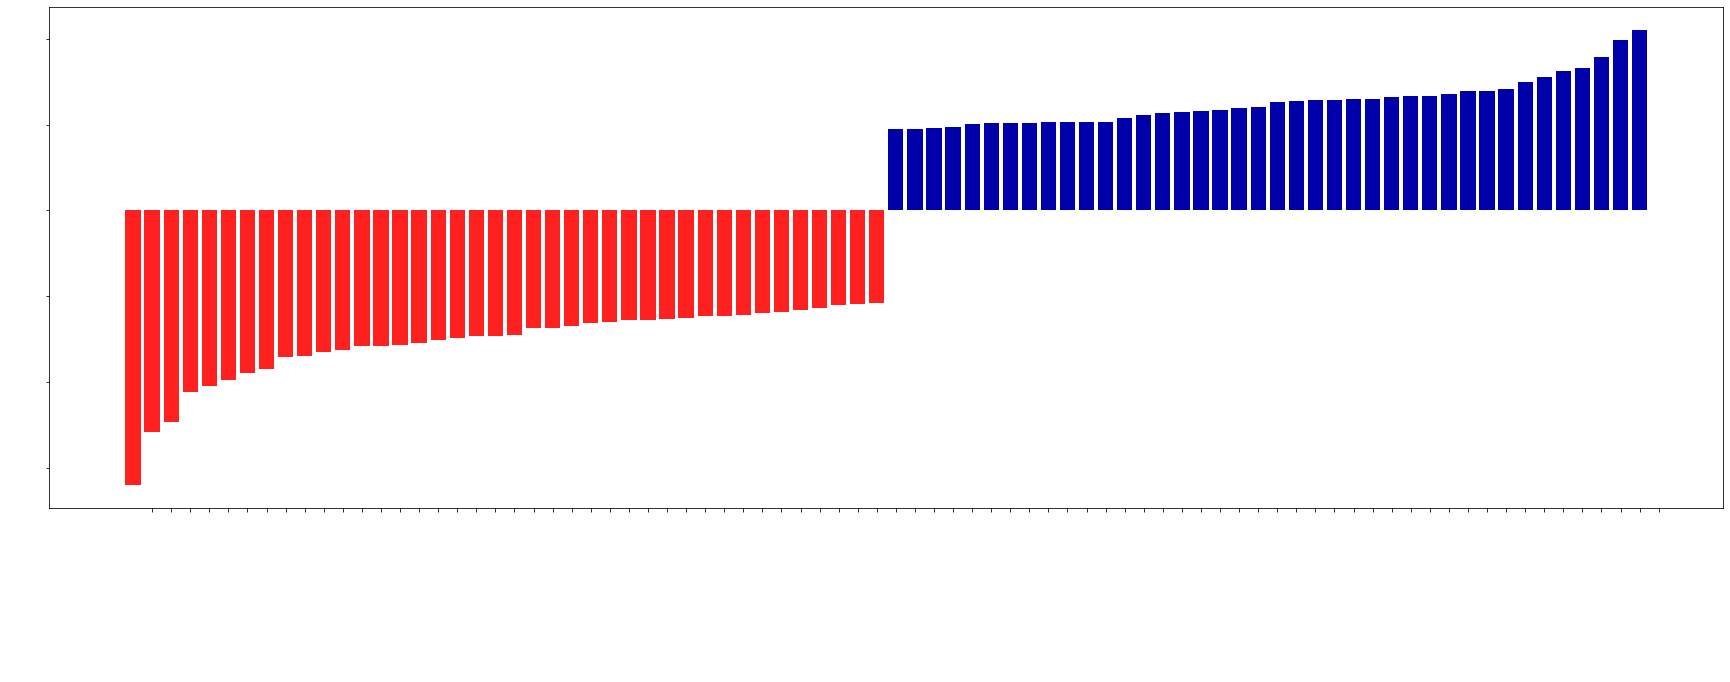

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from mglearn.plot_2d_separator import (plot_2d_separator, plot_2d_classification,
                                plot_2d_scores)
from mglearn.plot_helpers import cm2 as cm, discrete_scatter

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.

    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.

    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.

    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(30, 12))
    colors = [cm(1) if c < 0 else cm(0)
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right",color='white',size=20)
    plt.yticks(color='white')
    plt.ylabel("Coefficient magnitude",color='white')
    plt.xlabel("Feature",color='white')



visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_[0],
    feature_names, n_top_features=40)




# n-gram 활용 : 앞의 옵션들 모두 활용

In [ ]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# 매개변수 조합이 많고 트라이그램이 포함되어 있기 때문에
# 그리드 서치 실행에 시간이 오래 걸립니다
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("최상의 크로스 밸리데이션 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수:\n", grid.best_params_)

#진짜 오래걸림

최상의 크로스 밸리데이션 점수: 0.91
최적의 매개변수:
 {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


In [ ]:
print("테스트 점수: {:.2f}".format(grid.score(text_test, y_test)))

테스트 점수: 0.90


# 토픽 모델링과 문서 군집화: LDA

In [ ]:
vect = CountVectorizer(max_features=10000, max_df=.15) #전체의 15% 이상의 문서에 자주 나타나는 단어 제외, 최대 10,000개 단어
X = vect.fit_transform(text_train) # document를 넣음

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation


In [ ]:

lda = LatentDirichletAllocation(n_components=10, learning_method="batch",
                                max_iter=25, random_state=0) # 토픽 수 10개
# 모델 생성과 변환을 한 번에 합니다
# 변환 시간이 좀 걸리므로 시간을 절약하기 위해 동시에 처리합니다
document_topics = lda.fit_transform(X)

In [ ]:
topic_num=10

In [ ]:
# 토픽마다(components_의 행) 특성을 오름차순으로 정렬합니다
# 내림차순이 되도록 [:, ::-1] 사용해 행의 정렬을 반대로 바꿉니다
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
# CountVectorizer 객체에서 특성 이름을 구합니다.
feature_names = np.array(vect.get_feature_names())

In [ ]:
def print_topics(topics, feature_names, sorting, topics_per_chunk=6,
                 n_words=20):
    for i in range(0, len(topics), topics_per_chunk):
        # for each chunk:
        these_topics = topics[i: i + topics_per_chunk]
        # maybe we have less than topics_per_chunk left
        len_this_chunk = len(these_topics)
        # print topic headers
        print(("topic {:<8}" * len_this_chunk).format(*these_topics))
        print(("-------- {0:<5}" * len_this_chunk).format(""))
        # print top n_words frequent words
        for i in range(n_words):
            try:
                print(("{:<14}" * len_this_chunk).format(
                    *feature_names[sorting[these_topics, i]]))
            except:
                pass
        print("\n")


print_topics(topics=range(topic_num), feature_names=feature_names,
                           sorting=sorting, topics_per_chunk=5, n_words=10)

topic 0       topic 1       topic 2       topic 3       topic 4       
--------      --------      --------      --------      --------      
between       war           funny         show          didn          
young         world         worst         series        saw           
family        us            comedy        episode       am            
real          our           thing         tv            thought       
performance   american      guy           episodes      years         
beautiful     documentary   re            shows         book          
work          history       stupid        season        watched       
each          new           actually      new           now           
both          own           nothing       television    dvd           
director      point         want          years         got           


topic 5       topic 6       topic 7       topic 8       topic 9       
--------      --------      --------      --------      --------      
horr

In [ ]:
animation = np.argsort(document_topics[:,6])[::-1]
for i in animation[:10]:
  print(b".".join(text_train[i].split(b".")[:2])+b".\n") #10개의 리뷰 안에 2문장씩 보임

b'Rated E   I never actually owned a Nintendo 64 but I have played one many times.In my opinion along with Conkers Bad Fur Day, Super Mario 64 is one of the best video games for the Nintendo 64 system.\n'
b'First things first, I was never once scared of this underrated gem as a kid ("Little Mermaid" on the other hand..\n'
b'All Dogs Go To Heaven Is The Most Cutest Animated Film To Have Dogs In 1989. The Previous Don Bluth Film The Land Before Time(1988) Became A Success.\n'
b'First off, I want to say, "Thanks, Disney, for finally releasing the "Cinderella" movie on DVD! Now you have all the Disney animated films on DVD (including the 1999 Limited Editions)! What are you going to do next? You\'re going to Disney World!!!!!" Well, technically (I mean, look at the castle!!!!!)  Anyways, Disney remains magical in his 1950 animated classic film "Cinderella," the movie that put fairy tale movies on the map. We are all familiar with the story of Cinderella, her stepsisters, her date, the glas

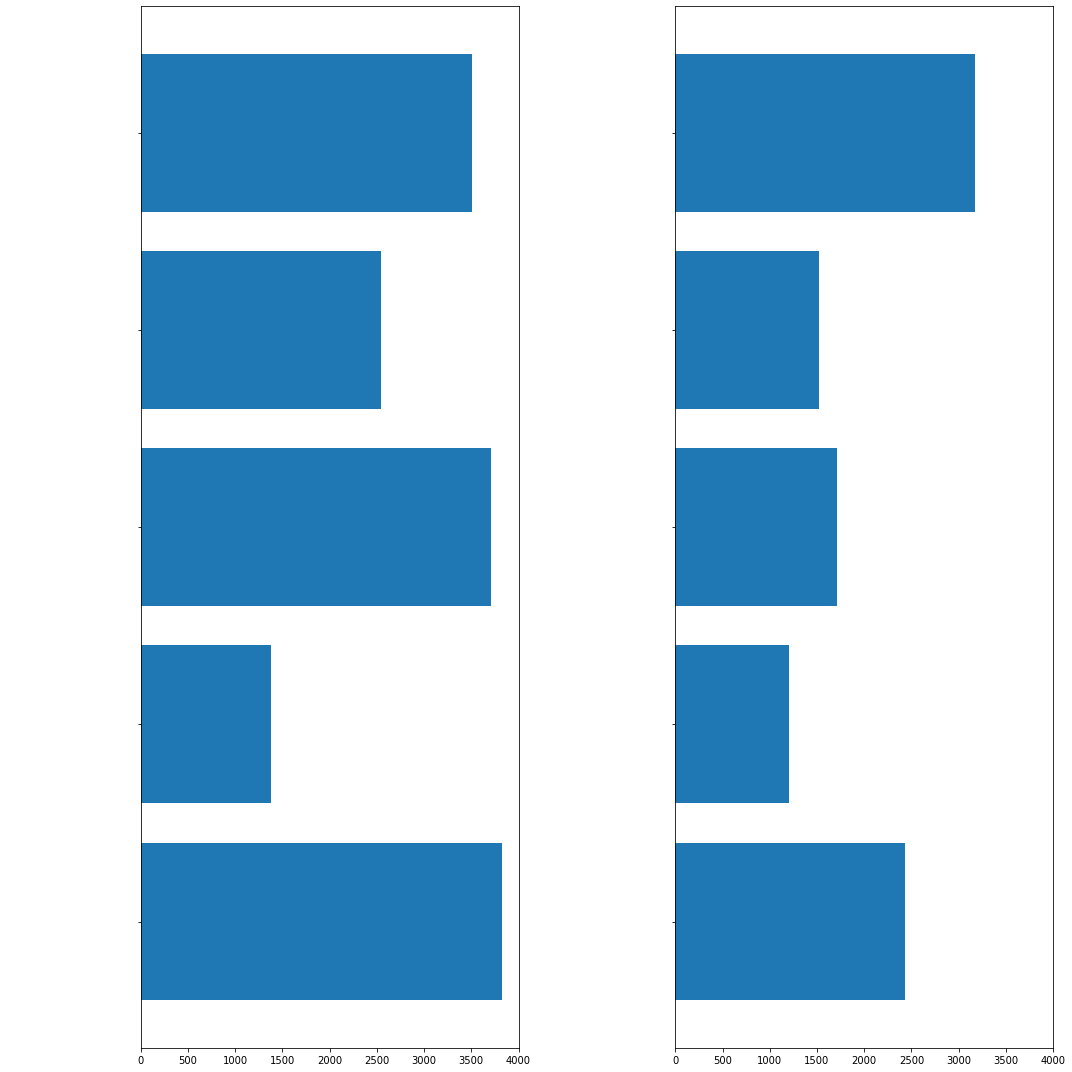

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

# 각 토픽을 대표하는 2개의 단어를 붙여 토픽 이름을 만듦
topic_names = ["{:>2} ".format(i) + " ".join(words)
               for i, words in enumerate(feature_names[sorting[:, :2]])]

# 두 개의 열이 있는 막대 그래프



for col in [0, 1]:
    start = col * 5
    end = (col + 1) * 5

    ax[col].barh(np.arange(5), np.sum(document_topics, axis=0)[start:end])
    ax[col].set_yticks(np.arange(5))
    ax[col].set_yticklabels(topic_names[start:end], ha="left", va="top",color='white',fontsize=12)
    ax[col].invert_yaxis()
    ax[col].set_xlim(0, 4000)
    yax = ax[col].get_yaxis()
    yax.set_tick_params(pad=130)

plt.tight_layout()